## Fashion Recommendation System

### Team Members
2. Aditya Krishnan
2. Bharat Kathuria
3. Pinal Bipin Gajjar
4. Aditya Singh

### Dataset Attributes

1. **ID**: `Numeric` - The unique identifier of the product data.
2. **Gender**: `Categorical` - Specifies for which gender the product is made.
3. **MasterCategory**: `Categorical` - The main category by which products are divided (eg. Apparel, Accessories).
4. **SubCategory**: `Categorical` - More specified category for clothing (eg. Topwear, Bottomwear, Watches).
5. **ArticleType**: `Categorical` - Shows the product type (eg. Shirts, Jeans, Watches, Tshirts).
6. **BaseColor**: `Categorical` - The color of the product.
7. **Season**: `Categorical` - It describes the season for which the product is suitable.
8. **Year**: `Numeric` - The manufacturing year of the product.
9. **Usage**: `Categorical` - The clothing style of product (eg. Casual, Formal).
10. **ProductDisplayName**: `Categorical` - The product name displayed on the website.

### Data Characteristics

- **Number of Use Cases**: 44446
- **Total Attributes**: 10
- **Data Types**:
  - `Gender`, `MasterCategory`, `SubCategory`, `ArticleType`, `BaseColor`, `Season`, `Usage`, `ProductDisplayName`: Categorical (String/Ordinal)
  - `ID`, `Year`: Numerical (Integer, Float)

Utilizing this dataset allows for a comprehensive analysis of how the various characteristics of product affects the recommendation system.

### Importing the required libraries

In [54]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import streamlit as st
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tqdm import tqdm

### Data Loading

In [44]:
# loading the CSV file into a Pandas DataFrame
df = pd.read_csv('./datasets/styles.csv', usecols=range(10)) # to remove any unnecessary data

# displaying the first few rows of the dataset
print(df.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


#### Note
We have 10 attributes which can be used to identify the product.

### Data Summary & Descriptive

In [45]:
# checking the basic statistics of numeric columns
print(df.describe())

                 id          year
count  44446.000000  44445.000000
mean   29692.631350   2012.805940
std    17048.234982      2.126401
min     1163.000000   2007.000000
25%    14770.250000   2011.000000
50%    28609.500000   2012.000000
75%    44678.750000   2015.000000
max    60000.000000   2019.000000


In [46]:
# checking for the number of products in the dataset
print("Number of products: ",df.shape[0])

# checking the data types of each column
print(df.dtypes)

Number of products:  44446
id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
dtype: object


### Checking for missing values & unique counts

In [48]:
# checking for missing values
print("\nMissing values:")
print(df.isnull().sum())

# counting the number of unique values in each column
print("\nUnique value counts:")
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")


Missing values:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

Unique value counts:
id: 44446 unique values
gender: 5 unique values
masterCategory: 7 unique values
subCategory: 45 unique values
articleType: 143 unique values
baseColour: 46 unique values
season: 4 unique values
year: 13 unique values
usage: 8 unique values
productDisplayName: 31135 unique values


#### Note
We can note that there are few missing values in our dataset. Most are in the usage column. Furthermore, we have 5 genders, 7 main categories, 45 sub categories, 143 product type, 46 product color, 4 seasons and 8 usages of the product style.

### Checking for duplicates

In [49]:
duplicated_rows = df[df.duplicated()]

# getting the count of duplicated rows
num_duplicated_rows = duplicated_rows.shape[0]
print('number of duplicate rows', num_duplicated_rows)

number of duplicate rows 0


#### Note
We can confirm that there are no duplicates in our data.

### Data visualization

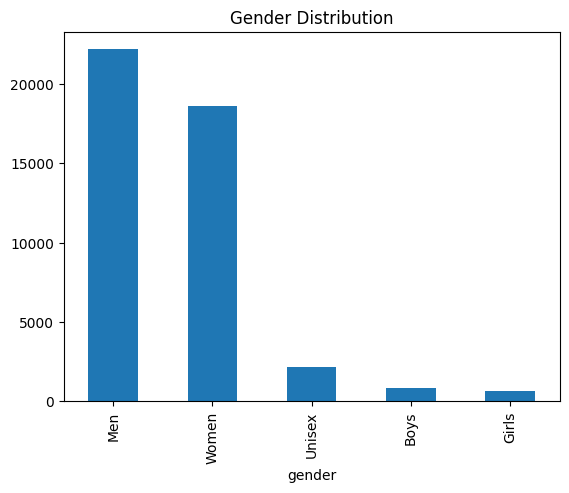

In [55]:
# checking the distribution of products by gender
df['gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.show()

#### Note
We can observe that most products fall under two genders Male and Female.

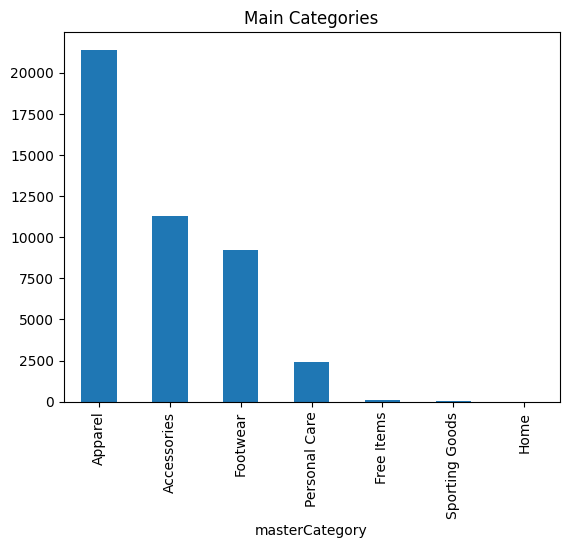

In [56]:
# checking the distribution of products by main category
df['masterCategory'].value_counts().plot(kind='bar')
plt.title('Main Categories')
plt.show()

#### Note
We can observe that Apparel contains the highest number of products followed by Accessories and Footwear. Whereas Free Items, Sporting Goods and Home have the least number of products.

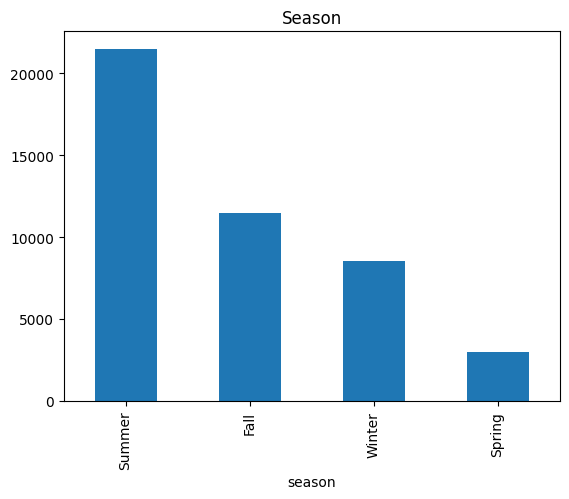

In [57]:
# checking the distribution of products by season
df['season'].value_counts().plot(kind='bar')
plt.title('Season')
plt.show()

#### Note
We can observe that Summer Season is having the highest number of product. Fall, Winter and Spring have a decreasing order.

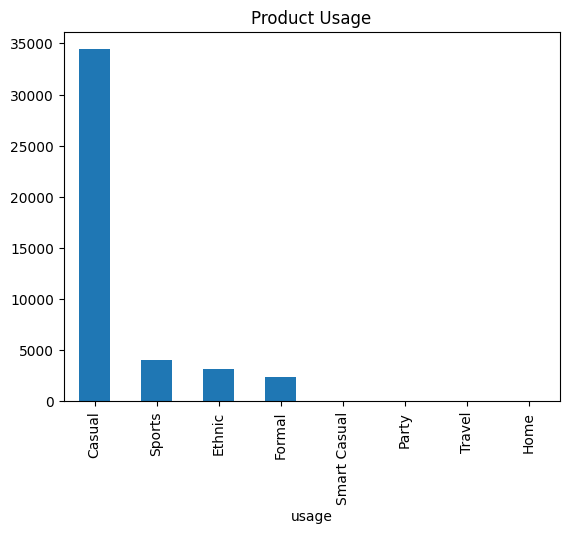

In [58]:
# checking the distribution of products by usage
df['usage'].value_counts().plot(kind='bar')
plt.title('Product Usage')
plt.show()

#### Note
We can note that most products are listed as Casual wear(usage), there are less than 5000 products for Sports, Ethinic and Formal. While, other usages have least amount of products.

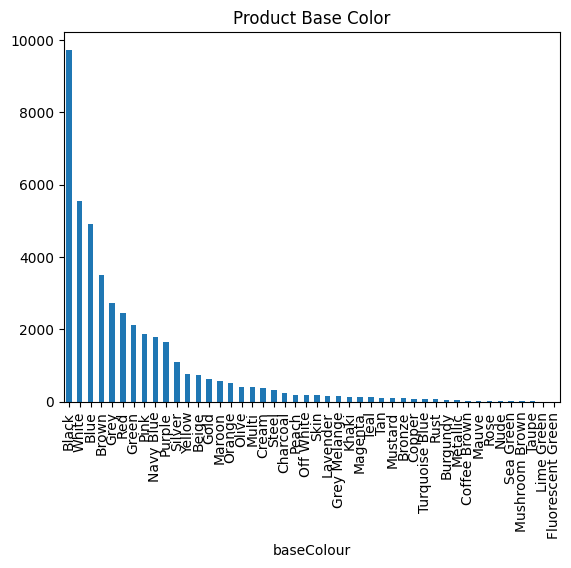

In [59]:
# checking the distribution of products by Color
df['baseColour'].value_counts().plot(kind='bar')
plt.title('Product Base Color')
plt.show()

#### Note
We can observe a trend of black color clothes, followed by white, blue, brown and grey with most of the product distribution

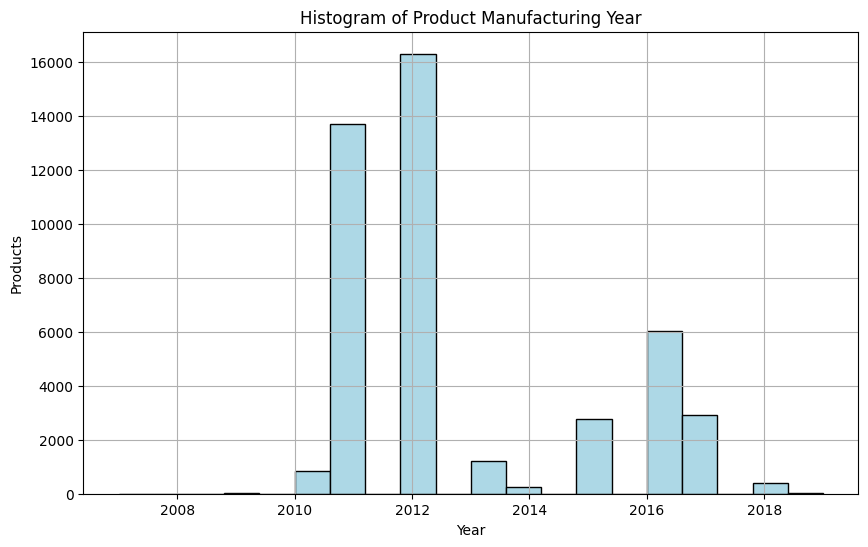

In [60]:
# Histogram of Year using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(df['year'], bins=20, color='lightblue', edgecolor='black')
plt.title('Histogram of Product Manufacturing Year')
plt.xlabel('Year')
plt.ylabel('Products')
plt.grid(True)
plt.show()

Enable GPU

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


Dataset Source:
https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small/code

<h2>Model Architecture For the Baseline Model:</h2>
<ul>
    <li><strong>Sequential Model:</strong> Stacks layers sequentially where each layer connects only to the following layer.</li>
    <li><strong>1st Convolutional Layer:</strong>
        <ul>
            <li><strong>Conv2D with 192 filters:</strong> Learns 192 distinct patterns.</li>
            <li><strong>Kernel size:</strong> 3x3.</li>
            <li><strong>Activation function:</strong> 'relu' (Rectified Linear Unit).</li>
            <li><strong>Input shape:</strong> (150, 150, 3) - for 150x150 pixel RGB images.</li>
            <li><strong>MaxPooling2D:</strong> Pooling operation with a 2x2 window to reduce spatial dimensions.</li>
        </ul>
    </li>
    <li><strong>2nd Convolutional Layer:</strong>
        <ul>
            <li><strong>Conv2D with 256 filters:</strong> Learns additional patterns with more filters.</li>
            <li><strong>Kernel size:</strong> 3x3.</li>
            <li><strong>Activation:</strong> 'relu'.</li>
            <li><strong>MaxPooling2D:</strong> Further reduces spatial dimensions.</li>
        </ul>
    </li>
    <li><strong>3rd Convolutional Layer:</strong>
        <ul>
            <li><strong>Conv2D with 64 filters:</strong> Focuses on higher-level features.</li>
            <li><strong>Kernel size:</strong> 3x3.</li>
            <li><strong>Activation:</strong> 'relu'.</li>
            <li><strong>MaxPooling2D:</strong> Additional reduction in spatial dimensions.</li>
        </ul>
    </li>
    <li><strong>4th Convolutional Layer:</strong>
        <ul>
            <li><strong>Conv2D with 128 filters:</strong> Increases filters for richer representation.</li>
            <li><strong>Kernel size:</strong> 3x3.</li>
            <li><strong>Activation:</strong> 'relu'.</li>
            <li><strong>MaxPooling2D:</strong> Final pooling layer.</li>
        </ul>
    </li>
    <li><strong>Flatten Layer:</strong> Flattens the output to 1D for the following dense layers.</li>
    <li><strong>Dense Layer:</strong>
        <ul>
            <li><strong>Units:</strong> 480 neurons.</li>
            <li><strong>Activation:</strong> 'relu'.</li>
        </ul>
    </li>
    <li><strong>Dropout Layer:</strong>
        <ul>
            <li><strong>Rate:</strong> 0.5 - Randomly sets half of the neuron outputs to zero.</li>
        </ul>
    </li>
    <li><strong>Output Layer:</strong>
        <ul>
            <li><strong>Units:</strong> 142 neurons (one for each class).</li>
            <li><strong>Activation:</strong> 'softmax' - for multi-class classification.</li>
        </ul>
    </li>
    <li><strong>Compilation:</strong>
        <ul>
            <li><strong>Optimizer:</strong> 'adam'.</li>
            <li><strong>Loss function:</strong> 'categorical_crossentropy'.</li>
            <li><strong>Metrics:</strong> 'accuracy'.</li>
        </ul>
    </li>
    <li><strong>Early Stopping Callback:</strong> Monitors validation accuracy with a patience of 10 epochs.</li>
</ul>
<p>Call <code>model.summary()</code> to print out the architecture including layer types, output shapes, and parameter counts.</p>

Now, let us use Keras Tuner to determine the optimal number of convolution layers, and hyperparameters including the filter sizes in each layer to build an optimal model for the problem.

In [9]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras_tuner import HyperModel

class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        input_layer = Input(shape=self.input_shape)
        x = input_layer

        # Tuning the number of convolutional layers
        for i in range(hp.Int('num_conv_layers', 1, 5)):  # Example range: 1 to 5 convolutional layers
            x = Conv2D(
                filters=hp.Int(f'filters_{i}', 32, 256, step=32),
                kernel_size=(3, 3),
                activation='relu'
            )(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

        # Feature extraction layer
        feature_layer = Conv2D(128, (3, 3), activation='relu')(x)  
        feature_extractor = Model(inputs=input_layer, outputs=feature_layer)

        # Adding Flatten and Dense layers for classification
        x = Flatten()(feature_layer)
        x = Dense(
            hp.Int('units', min_value=32, max_value=512, step=32),
            activation='relu'
        )(x)
        output_layer = Dense(self.num_classes, activation='softmax')(x)

        # Complete model for training
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

In [10]:
my_hypermodel = MyHyperModel(input_shape=(150, 150, 3), num_classes=142)

In [11]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    my_hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='my_tuner_project'
)

Reloading Tuner from my_tuner_dir\my_tuner_project\tuner0.json


Uncomment the below block when running keras tuner search again.

In [12]:
# tuner.search(
#     train_generator,  # assuming this is your training data generator
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size
# )

In [13]:
best_model = tuner.get_best_models(num_models=1)[0]

In [14]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Access a specific hyperparameter
num_layers = best_hyperparameters.get('num_conv_layers')
print(f"Best number of layers: {num_layers}")

# Print all hyperparameter values
print("All best hyperparameters:")
for hp_name in best_hyperparameters.space:
    print(f"{hp_name.name}: {best_hyperparameters.get(hp_name.name)}")

Best number of layers: 4
All best hyperparameters:
num_conv_layers: 4
filters_0: 192
units: 480
filters_1: 256
filters_2: 64
filters_3: 128
filters_4: 128


Define Data Generators for train, test and validation data. We perform the following Data Augmentation steps below to increase the variety in the data and introduce little nuances of the same data while training the model: scaling, rotation, zoom, and horizontal flip. 70% of the total data is in training, 15% is in validation and 15% in testing.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# Paths to the train, validation, and test directories
train_dir = './datasets/train/'
validation_dir = './datasets/validation/'
test_dir = './datasets/test/'

# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale validation and test data
test_val_datagen = ImageDataGenerator(rescale=1.0/255)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = test_val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test data generator
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 31026 images belonging to 142 classes.
Found 6597 images belonging to 142 classes.
Found 6796 images belonging to 142 classes.


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model parameters
input_shape = (150, 150, 3)  # Adjust based on your image dimensions
num_classes = 142  # Adjust based on the number of classes you have

# Initialize the model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(192, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and use dense layers
model.add(Flatten())
model.add(Dense(480, activation='relu'))  # Dense layer with units as per hyperparameters
model.add(Dropout(0.5))  # You can adjust the dropout rate if needed
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 192)     5376      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 192)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 256)       442624    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        147520    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)       0

Model Fitting

In [17]:
# # Train the Model
# epochs = 50
# batch_size = 32
# model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // batch_size,
#     callbacks=[early_stopping]
# )

Train Accuracy: 74.88 <br>
Val Accuracy: 79.00<br>
Val Loss: 69.36

Save the model for predictions

In [18]:
# model.save(filepath="./models/model2_final.keras")

In [19]:
# # Save the model
# model.save('model2_final.h5')  # Creates a HDF5 file 'my_model.h5'

Load the pre trained model

In [20]:
from keras.models import load_model

# Load the model
saved_model = load_model('./models/model2_final.keras')

Model evaluation on test data

In [21]:
# Evaluate the model
loss, accuracy = saved_model.evaluate(test_generator)

# Print the results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

213/213 [==============================] - 27s 83ms/step - loss: 0.8265 - accuracy: 0.7749
Test Loss: 0.8264647126197815
Test Accuracy: 0.774867594242096


Model evaluation on train data

In [22]:
# Evaluate the model
loss, accuracy = saved_model.evaluate(train_generator)

# Print the results
print("Train Loss:", loss)
print("Train Accuracy:", accuracy)

970/970 [==============================] - 374s 386ms/step - loss: 0.7535 - accuracy: 0.7600
Train Loss: 0.753473162651062
Train Accuracy: 0.7600077390670776


Model evaluation on validation set

In [23]:
# Evaluate the model
loss, accuracy = saved_model.evaluate(validation_generator)

# Print the results
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

207/207 [==============================] - 22s 107ms/step - loss: 0.7201 - accuracy: 0.7848
Validation Loss: 0.7201240062713623
Validation Accuracy: 0.7847506403923035


Model evaluation with metrics on train data.

In [24]:
from sklearn.metrics import classification_report

# Predict classes on training data
train_generator.reset()
train_predictions = saved_model.predict(train_generator)
train_pred_classes = np.argmax(train_predictions, axis=1)

# Get true class labels
train_true_classes = train_generator.classes

print(train_pred_classes, train_true_classes)

970/970 [==============================] - 11045s 11s/step
[ 84 126 112 ... 119 100  27] [  0   0   0 ... 141 141 141]


In [25]:
# Get the list of class indices
class_labels = list(range(len(train_generator.class_indices)))

In [26]:
# Calculate classification report
train_class_report = classification_report(train_true_classes,
                                           train_pred_classes,
                                           labels=class_labels,
                                           target_names=train_generator.class_indices.keys())
print("Training Data Classification Report:\n", train_class_report)

Training Data Classification Report:
                            precision    recall  f1-score   support

       Accessory Gift Set       0.00      0.00      0.00        67
               Baby Dolls       0.00      0.00      0.00        11
                Backpacks       0.01      0.01      0.01       506
                   Bangle       0.00      0.00      0.00        59
              Basketballs       0.00      0.00      0.00         9
                Bath Robe       0.00      0.00      0.00        14
         Beauty Accessory       0.00      0.00      0.00         2
                    Belts       0.02      0.02      0.02       569
                  Blazers       0.00      0.00      0.00         5
              Body Lotion       0.00      0.00      0.00         4
      Body Wash and Scrub       0.00      0.00      0.00         0
                  Booties       0.00      0.00      0.00         8
                   Boxers       0.00      0.00      0.00        36
                      B

c:\AI\recommender_system\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\AI\recommender_system\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\AI\recommender_system\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\AI\recommender_system\.venv\lib\site-packa

<h4>Inference from Baseline Model Training and Evaluation</h4>

From the above model evaluations, we can infer that the baseline model with a smaller version of our original dataset has a decent accuracy during training, testing and evaluation. However, the classification report above on training data indicates that the model has an extremely precision, and recall values. This could be due to several factors including class imbalance, insufficient training data for certain classes, or a model that is not well-suited to the problem.

<h4>Immediate Next Steps for Model Improvement:</h4>
1. Introducing more images for the different classes to improve the class imbalance and to eradicate the problem of the model seeing very few samples in some of the classes.<br>
2. Ensuring that the dataset is balanced possibly by introducing class weights.<br>
3. Consider using data augmentation techniques to increase the variety of training samples.<br>
4. Use techniques like transfer learning using pretrained models like RESNet when working with a limited dataset.<br>

<h4>Additional next steps for building a recommendation system:</h4>
1. We would use the current baseline model as well as the future models we build based on above improvements to extract features. <br>
2. If we keep the above architecture of the model intact, we would use the output of the last convolution layer to extract features. This is because the last layer should have learned to represent high-level features of the input images that are most discriminative for the different classes belonging to different types of fashion or clothing items.<br>
3. We would use the feature extractor to extract features for any input image given as a query.<br>
4. We would then use appropriate distance measure to find the top-n items to recommend.<br>

Generating Recommendations on RESNET50 Pretrained Model using transfer learning

In [27]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# we set model.trainable to False as we just need to extract features
model.trainable = False
model = Sequential([model, GlobalMaxPooling2D()])

In [35]:
def extract_features(img_path, model):
    # Load the image from the given file path. The target size is set to 224x224 to match the input size expected by the model.
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert the loaded image to a NumPy array. This creates a 3D array (height, width, channels).
    img_array = image.img_to_array(img)

    # Expand the dimensions of the array to include the batch size as the first dimension, 
    # which is required for the model to process the image. The resulting array becomes 4D (batch size, height, width, channels).
    expanded_img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image data (e.g., scaling pixel values) to match the format expected by the model.
    preprocessed_img = preprocess_input(expanded_img_array)

    # Use the model to make a prediction on the preprocessed image. 
    # The result is typically a feature vector corresponding to the image.
    result = model.predict(preprocessed_img).flatten()

    # Normalize the result to ensure that feature vectors have a similar scale. 
    # This can improve the performance of subsequent operations like clustering or classification.
    normalized_result = result / norm(result)

    return normalized_result


In [36]:
filenames = []
for file in os.listdir('images'):
    filenames.append(os.path.join('images', file))

Uncomment below code to dump feature list into pickle files

In [30]:
# feature_list = []
# for file in tqdm(filenames):
#     feature_list.append(extract_features(file, model))

# pickle.dump(feature_list,open('embeddings.pkl','wb'))
# pickle.dump(filenames,open('filenames.pkl','wb'))

In [37]:
# Custom Function for Layout and Styling
def set_layout_style():
    st.markdown("""
        <style>
            .main {background-color: #f0f2f6;}
            .stButton>button {width: 100%;}
            .st-bb {margin-top: -20px;}
            .st-eb {margin-bottom: -20px;}
            img {max-width: 100%;}
        </style>
        """, unsafe_allow_html=True)

In [38]:
set_layout_style()

In [39]:
# Load feature list and filenames from pickled files
feature_list = np.array(pickle.load(open('embeddings.pkl', 'rb')))
filenames = pickle.load(open('filenames.pkl', 'rb'))

In [40]:
from PIL import Image
from numpy.linalg import norm
from annoy import AnnoyIndex

In [41]:
# Streamlit title
st.title('Fashion Recommender System')

# Sidebar for User Settings
st.sidebar.header('Settings')
n_recommendations = st.sidebar.slider('Number of Recommendations', min_value=1, max_value=10, value=6)
st.sidebar.text('Adjust the number of recommendations here.')


# Function to build and return an Annoy index
def build_annoy_index(feature_list, num_trees=10):
    f = feature_list.shape[1]
    t = AnnoyIndex(f, 'angular')
    for i in range(feature_list.shape[0]):
        t.add_item(i, feature_list[i])
    t.build(num_trees)
    return t


# Load or build Annoy index
try:
    f = feature_list.shape[1]
    annoy_index = AnnoyIndex(f, 'angular')
    annoy_index.load('fashion.ann')  # Load pre-built index
except:
    annoy_index = build_annoy_index(feature_list)
    annoy_index.save('fashion.ann')


# Function for recommending items
def recommend(features, annoy_index, n=6):
    indices = annoy_index.get_nns_by_vector(features, n)
    return indices


# Function to extract features from an image
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result


# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model = tf.keras.Sequential([model, GlobalMaxPooling2D()])


# Function to save the uploaded file
def save_uploaded_file(uploaded_file):
    try:
        os.makedirs('uploads', exist_ok=True)  # Create 'uploads' directory if it doesn't exist
        with open(os.path.join('uploads', uploaded_file.name), 'wb') as f:
            f.write(uploaded_file.getbuffer())
        return True
    except Exception as e:
        print(e)  # You can use st.error to display the error on the frontend
        return False


# File uploader
uploaded_file = st.file_uploader("Choose an image", type=['png', 'jpg', 'jpeg'])
if uploaded_file is not None:
    if save_uploaded_file(uploaded_file):
        # Display the uploaded file
        display_image = Image.open(uploaded_file)
        st.image(display_image, caption='Uploaded Image', use_column_width=True)

        with st.spinner('Finding recommendations...'):
            # Extract features and get recommendations
            features = extract_features(os.path.join("uploads", uploaded_file.name), model)
            indices = recommend(features, annoy_index, n=n_recommendations)

            # Display recommended items
            for idx in indices:
                st.image(filenames[idx], use_column_width=True, caption=f'Recommended Item {idx + 1}')
            st.success('Recommendations generated!')
    else:
        st.error("Error in file upload. Please try again.")

# About section
with st.expander("About this App"):
    st.write("""
        This Fashion Recommender System uses advanced machine learning techniques to suggest fashion items similar to the uploaded image. Whether you're looking for outfit inspirations or the latest fashion trends, this tool helps you discover them effortlessly.
    """)